## Steps for preprocessing

Calculate the sum of taxable_value for the sales data and the sum of deposit_amount for the bank data.

Merge the two aggregated DataFrames on the company_id.

Create the discrepancy column by subtracting the total deposit_amount from the total taxable_value for each company.


In [1]:
# Getting the deposit amount for the B2C sales for each company from the Bank Statements


import pandas as pd
import os
from google.colab import drive


bank_statements_folder = '/content/drive/My Drive/Capstone/B2C/bank_statements1_preprocessed'
# IMPORTANT: Update this path to your B2C Sales folder
b2c_sales_folder = '/content/drive/My Drive/Capstone/B2C/b2c_sales_fraud_cleaned'


# Processing Bank Statements
bank_data_list = []
print(f"Processing files in: {bank_statements_folder}")
try:
    for filename in os.listdir(bank_statements_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(bank_statements_folder, filename)
            company_id = filename.split('_')[0]
            try:
                df = pd.read_csv(file_path)
                b2c_transactions = df[~df['Narration'].astype(str).str.contains('(B2B)', regex=False)]
                total_b2c_deposit = b2c_transactions['Deposit Amt.'].sum()
                bank_data_list.append({'company_id': company_id, 'Deposit Amount': total_b2c_deposit})
            except Exception as e:
                print(f"Could not process bank file {filename}. Error: {e}")
except FileNotFoundError:
    print(f"Error: The folder path '{bank_statements_folder}' was not found.")

deposits_df = pd.DataFrame(bank_data_list)


# Processing B2C Sales Files
sales_data_list = []
print(f"\nProcessing files in: {b2c_sales_folder}")
try:
    for filename in os.listdir(b2c_sales_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(b2c_sales_folder, filename)
            company_id = filename.split('_')[0]
            try:
                df = pd.read_csv(file_path)
                total_taxable_value = df['Taxable Value'].sum()
                sales_data_list.append({'company_id': company_id, 'Taxable Value': total_taxable_value})
            except Exception as e:
                print(f"Could not process sales file {filename}. Error: {e}")
except FileNotFoundError:
    print(f"Error: The folder path '{b2c_sales_folder}' was not found.")

taxable_value_df = pd.DataFrame(sales_data_list)


# Finalization: Merge Datasets and Save
if not deposits_df.empty and not taxable_value_df.empty:
    final_dataset = pd.merge(deposits_df, taxable_value_df, on='company_id', how='outer')

    # Handle missing values after merge
    # If a company is in one dataset but not the other, fill the missing value with 0.
    final_dataset['Taxable Value'] = final_dataset['Taxable Value'].fillna(0)
    final_dataset['Deposit Amount'] = final_dataset['Deposit Amount'].fillna(0)

    # Calculate the Discrepancy column
    final_dataset['Discrepancy'] = final_dataset['Deposit Amount'] - final_dataset['Taxable Value']

    # Round tiny floating point discrepancies to zero
    # Any discrepancy with an absolute value less than 1e-6 will be set to 0.
    final_dataset.loc[final_dataset['Discrepancy'].abs() < 1e-6, 'Discrepancy'] = 0

    print("\n--- Combined B2C Dataset ---")
    print(final_dataset.head())

    # Save your new dataset to a CSV file
    output_path = '/content/drive/My Drive/Capstone/B2C/b2c_preprocessed.csv'
    final_dataset.to_csv(output_path, index=False)
    print(f"\nDataset saved to: {output_path}")

else:
    print("\nCould not create final dataset. One or both of the source folders were empty or could not be processed.")

Processing files in: /content/drive/My Drive/Capstone/B2C/bank_statements1_preprocessed
Error: The folder path '/content/drive/My Drive/Capstone/B2C/bank_statements1_preprocessed' was not found.

Processing files in: /content/drive/My Drive/Capstone/B2C/b2c_sales_fraud_cleaned
Error: The folder path '/content/drive/My Drive/Capstone/B2C/b2c_sales_fraud_cleaned' was not found.

Could not create final dataset. One or both of the source folders were empty or could not be processed.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix
)

# -----------------------------
# 1. Load Data
# -----------------------------

In [3]:
DATA_PATH = "/content/drive/MyDrive/Capstone Preprocessing/B2C/b2c_preprocessed.csv"
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)


Data shape: (100, 4)


# -----------------------------
# 2. Use 'Discrepancy' column as ground truth (binary)
# -----------------------------

In [4]:
if "Discrepancy" not in df.columns:
    raise ValueError("Expected 'Discrepancy' column not found in dataset!")

# Convert discrepancy into binary labels: 0 = normal, >0 = anomaly
y = (df["Discrepancy"] > 0).astype(int)

n_fraud = y.sum()
n_total = len(y)
fraud_pct = n_fraud / n_total
contamination = fraud_pct  # for Isolation Forest

print(f"\nNumber of fraud companies: {n_fraud}")
print(f"Total companies: {n_total}")
print(f"Fraud percentage: {fraud_pct:.2%}")
print("Discrepancy label distribution:\n", y.value_counts())


Number of fraud companies: 8
Total companies: 100
Fraud percentage: 8.00%
Discrepancy label distribution:
 Discrepancy
0    92
1     8
Name: count, dtype: int64


# -----------------------------
# 3. Feature preparation
# -----------------------------

In [5]:
# Feature engineering
df['Log_Deposit'] = np.log1p(df['Deposit Amount'])
df['Log_Taxable'] = np.log1p(df['Taxable Value'])
df['Discrepancy_to_Deposit'] = np.where(
    df['Deposit Amount'] > 0,
    df['Discrepancy'] / df['Deposit Amount'],
    0
)
# Features for Isolation Forest (exclude target)
features = df[['Deposit Amount', 'Taxable Value', 'Log_Deposit', 'Log_Taxable', 'Discrepancy_to_Deposit']]


In [6]:
# -----------------------------
# 4. Scale features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 5. Train Isolation Forest

In [7]:

model = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=contamination,
    random_state=42
    # bootstrap=True
)
model.fit(X_scaled)

IsolationForest(contamination=np.float64(0.08), n_estimators=200,
                random_state=42)

# 6. Predict & Score

In [ ]:
pred_raw = model.predict(X_scaled)        # -1 = anomaly, 1 = normal
y_pred = (pred_raw == -1).astype(int)   # 1 = anomaly
scores = -model.score_samples(X_scaled)

df_results = df.copy()
df_results["predicted_anomaly"] = y_pred
df_results["anomaly_score"] = scores


# 7. Evaluation


Confusion Matrix:
 [[91  1]
 [ 1  7]]
Accuracy: 0.98
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
ROC AUC: 0.9986
Average Precision (PR AUC): 0.9861


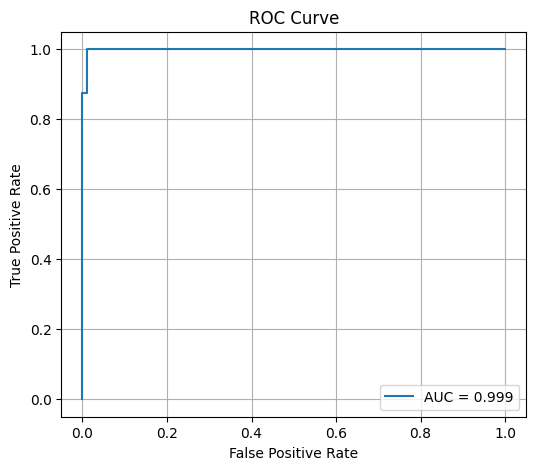

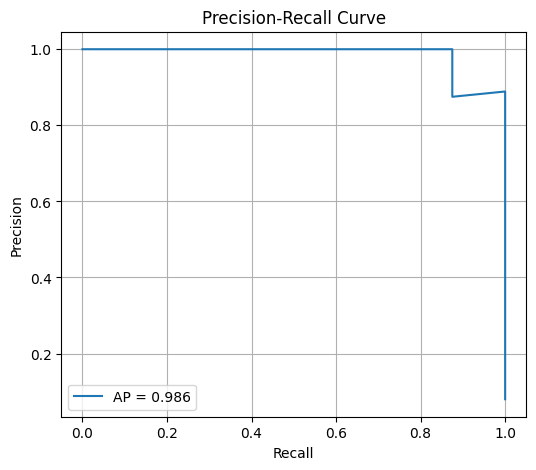


Total anomalous companies detected: 8

Anomalous Companies:

   company_id  Deposit Amount  Taxable Value   Discrepancy  Log_Deposit  \
4       1T2TA    4.178090e+08   0.000000e+00  4.178090e+08    19.850535   
14      5935A    8.811416e+07   8.811416e+07  0.000000e+00    18.294144   
17      5OWF7    2.517539e+08   1.391563e+08  1.125977e+08    19.343963   
24      6WKTA    3.814998e+08   0.000000e+00  3.814998e+08    19.759621   
85      UJZA7    3.724898e+08   2.544193e+08  1.180705e+08    19.735720   
86      VG0FN    2.852121e+08   0.000000e+00  2.852121e+08    19.468744   
90      XAJI0    3.574425e+08   1.875134e+08  1.699291e+08    19.694485   
98      ZKLOO    1.016885e+08   8.016318e+07  2.152528e+07    18.437424   

    Log_Taxable  Discrepancy_to_Deposit  predicted_anomaly  anomaly_score  
4      0.000000                1.000000                  1       0.735942  
14    18.294144                0.000000                  1       0.588842  
17    18.751108                0.4

In [8]:

acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, zero_division=0)
rec = recall_score(y, y_pred, zero_division=0)
f1 = f1_score(y, y_pred, zero_division=0)

print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1 Score: {f1:.2f}")

roc_auc = roc_auc_score(y, scores)
ap = average_precision_score(y, scores)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {ap:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y, scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
prec_vals, rec_vals, _ = precision_recall_curve(y, scores)
plt.figure(figsize=(6,5))
plt.plot(rec_vals, prec_vals, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()



# 8. Display anomalous companies



In [12]:
anomalous_companies = df_results[df_results["predicted_anomaly"] == 1]
print("\nTotal anomalous companies detected:", len(anomalous_companies))

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print("\nAnomalous Companies:\n")
print(anomalous_companies)


Total anomalous companies detected: 8

Anomalous Companies:

   company_id  Deposit Amount  Taxable Value   Discrepancy  Log_Deposit  \
4       1T2TA    4.178090e+08   0.000000e+00  4.178090e+08    19.850535   
14      5935A    8.811416e+07   8.811416e+07  0.000000e+00    18.294144   
17      5OWF7    2.517539e+08   1.391563e+08  1.125977e+08    19.343963   
24      6WKTA    3.814998e+08   0.000000e+00  3.814998e+08    19.759621   
85      UJZA7    3.724898e+08   2.544193e+08  1.180705e+08    19.735720   
86      VG0FN    2.852121e+08   0.000000e+00  2.852121e+08    19.468744   
90      XAJI0    3.574425e+08   1.875134e+08  1.699291e+08    19.694485   
98      ZKLOO    1.016885e+08   8.016318e+07  2.152528e+07    18.437424   

    Log_Taxable  Discrepancy_to_Deposit  predicted_anomaly  anomaly_score  
4      0.000000                1.000000                  1       0.735942  
14    18.294144                0.000000                  1       0.588842  
17    18.751108                0.4

In [11]:
# -----------------------------
# 8. Display anomalous companies
# -----------------------------
anomalous_companies = df_results[df_results["predicted_anomaly"] == 1].copy()

# Add Risk Level
anomalous_companies["Risk_Level"] = anomalous_companies["Taxable Value"].apply(
    lambda x: "Urgent" if x == 0 else "Investigate"
)

print("\nTotal anomalous companies detected:", len(anomalous_companies))

# -----------------------------
# 9. Display neatly
# -----------------------------
print(f"\n--- The model detected the following {len(anomalous_companies)} companies as anomalous: ---")
display(anomalous_companies[[
    "company_id", "Deposit Amount", "Taxable Value", "Discrepancy",
    "anomaly_score", "Risk_Level"
]])



Total anomalous companies detected: 8

--- The model detected the following 8 companies as anomalous: ---


,company_id,Deposit Amount,Taxable Value,Discrepancy,anomaly_score,Risk_Level
4,1T2TA,4.178090e+08,0.000000e+00,4.178090e+08,0.735942,Urgent
14,5935A,8.811416e+07,8.811416e+07,0.000000e+00,0.588842,Investigate
17,5OWF7,2.517539e+08,1.391563e+08,1.125977e+08,0.639328,Investigate
24,6WKTA,3.814998e+08,0.000000e+00,3.814998e+08,0.716386,Urgent
85,UJZA7,3.724898e+08,2.544193e+08,1.180705e+08,0.593448,Investigate
86,VG0FN,2.852121e+08,0.000000e+00,2.852121e+08,0.756565,Urgent
90,XAJI0,3.574425e+08,1.875134e+08,1.699291e+08,0.629347,Investigate
98,ZKLOO,1.016885e+08,8.016318e+07,2.152528e+07,0.684176,Investigate


Data shape: (100, 4)

Number of fraud companies: 8
Total companies: 100
Fraud percentage: 8.00%

--- Local Outlier Factor ---
Confusion Matrix:
 [[91  1]
 [ 3  5]]
Accuracy: 0.96, Precision: 0.83, Recall: 0.62, F1: 0.71
ROC AUC: 0.9715, PR AUC: 0.8290


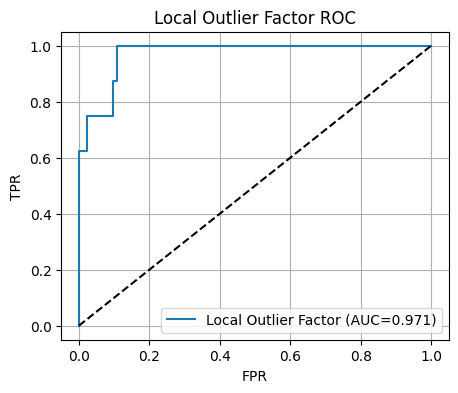


--- One-Class SVM ---
Confusion Matrix:
 [[84  8]
 [ 4  4]]
Accuracy: 0.88, Precision: 0.33, Recall: 0.50, F1: 0.40
ROC AUC: 0.7663, PR AUC: 0.5191


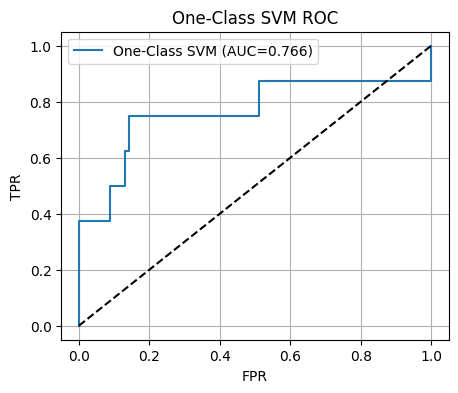


--- Elliptic Envelope ---
Confusion Matrix:
 [[85  7]
 [ 7  1]]
Accuracy: 0.86, Precision: 0.12, Recall: 0.12, F1: 0.12
ROC AUC: 0.8804, PR AUC: 0.2702


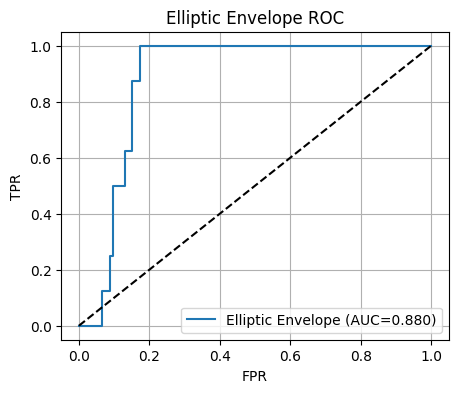

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix
)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# -----------------------------
# 1. Load Data
# -----------------------------
DATA_PATH = "/content/drive/MyDrive/Capstone Preprocessing/B2C/b2c_preprocessed.csv"
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)

# -----------------------------
# 2. Ground truth
# -----------------------------
y = (df["Discrepancy"] > 0).astype(int)
n_fraud = y.sum()
n_total = len(y)
contamination = n_fraud / n_total

print(f"\nNumber of fraud companies: {n_fraud}")
print(f"Total companies: {n_total}")
print(f"Fraud percentage: {contamination:.2%}")

# -----------------------------
# 3. Feature preparation
# -----------------------------
df['Log_Deposit'] = np.log1p(df['Deposit Amount'])
df['Log_Taxable'] = np.log1p(df['Taxable Value'])
df['Discrepancy_to_Deposit'] = np.where(
    df['Deposit Amount'] > 0,
    df['Discrepancy'] / df['Deposit Amount'],
    0
)
features = df[['Deposit Amount', 'Taxable Value', 'Log_Deposit', 'Log_Taxable', 'Discrepancy_to_Deposit']]

# -----------------------------
# 4. Scale features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# -----------------------------
# 5. Define models
# -----------------------------
models = {
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=50, contamination=contamination, novelty=True
    ),
    "One-Class SVM": OneClassSVM(
        kernel='rbf', gamma='scale', nu=contamination
    ),
    "Elliptic Envelope": EllipticEnvelope(
        contamination=contamination, random_state=42
    )
}

# -----------------------------
# 6. Train, predict & evaluate
# -----------------------------
for name, model in models.items():
    print(f"\n--- {name} ---")

    # For LOF, fit the model first
    if name == "Local Outlier Factor":
        model.fit(X_scaled)
        pred_raw = model.predict(X_scaled)
        scores = -model.decision_function(X_scaled)  # higher score = more anomalous
    else:
        model.fit(X_scaled)
        if name == "One-Class SVM" or name == "Elliptic Envelope":
            pred_raw = model.predict(X_scaled)
            scores = -model.score_samples(X_scaled)
        else:  # Isolation Forest
            pred_raw = model.predict(X_scaled)
            scores = -model.score_samples(X_scaled)

    y_pred = (pred_raw == -1).astype(int)

    # Evaluation
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y, scores)
    ap = average_precision_score(y, scores)

    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {ap:.4f}")

    # Optional: plot ROC curve
    fpr, tpr, _ = roc_curve(y, scores)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{name} ROC")
    plt.legend(); plt.grid(True); plt.show()
